# Competitors

28 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [97]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import h3

from scipy.spatial import KDTree
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, HDBSCAN
from INEGIpy import MarcoGeoestadistico

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitud'], gdf_properties['latitud']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 852931 entries, 0 to 853032
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   property_id                    852931 non-null  object        
 1   valor_fisico_construccion      852931 non-null  float64       
 2   id_avaluo                      852931 non-null  object        
 3   fecha_avaluo                   852931 non-null  datetime64[ns]
 4   colonia                        852931 non-null  object        
 5   id_clase_inmueble              852931 non-null  int64         
 6   id_tipo_inmueble               852931 non-null  int64         
 7   conservacion                   852931 non-null  float64       
 8   elevador                       824560 non-null  float64       
 9   niveles                        852931 non-null  int64         
 10  cve_ref_proximidad_urbana      852931 non-null  int64         
 1

In [4]:
# add property type
gdf_properties['property_type'] = np.where(
    gdf_properties['id_tipo_inmueble'].le(3), 'house', 'apartment'
)

## Cities

In [5]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/polygons_cities_analysis.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

gdf_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city_cluster  158 non-null    int64   
 1   geometry      158 non-null    geometry
 2   id_entidad_f  158 non-null    object  
 3   id_municipio  158 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 5.1+ KB


In [6]:
# see table
gdf_cities.head()

,city_cluster,geometry,id_entidad_f,id_municipio
0,0,"POLYGON ((2802508.846 807491.784, 2789672.652 ...",09,003
1,1,"POLYGON ((1629955.271 1907389.003, 1627448.198...",26,030
2,2,"POLYGON ((3774584.424 1040369.440, 3771144.074...",31,050
3,3,"POLYGON ((1689809.795 1228251.713, 1688632.431...",03,008
4,4,"POLYGON ((2925744.121 1137557.697, 2925578.403...",28,003


## Wrangle

In [7]:
# get area of each city
gdf_cities["area_city_km2"] = gdf_cities["geometry"].area / 1e+6
gdf_cities.head()

,city_cluster,geometry,id_entidad_f,id_municipio,area_city_km2
0,0,"POLYGON ((2802508.846 807491.784, 2789672.652 ...",09,003,2903.853661
1,1,"POLYGON ((1629955.271 1907389.003, 1627448.198...",26,030,209.540815
2,2,"POLYGON ((3774584.424 1040369.440, 3771144.074...",31,050,421.923013
3,3,"POLYGON ((1689809.795 1228251.713, 1688632.431...",03,008,51.820147
4,4,"POLYGON ((2925744.121 1137557.697, 2925578.403...",28,003,189.037742


In [8]:
# join data
gdf_properties = (
    gdf_properties
    .sjoin(
        gdf_cities.loc[:, ["city_cluster", "geometry", 'area_city_km2']],
        how="left",
    )
    .drop_duplicates(subset=["property_id"], keep="first")
    .drop(columns=["index_right"])
)

# see shape
gdf_properties.shape

(852931, 45)

In [158]:
# fill nan values of elevador with 0
gdf_properties['elevador'] = gdf_properties['elevador'].fillna(0)

In [9]:
gdf_properties.head()

,property_id,valor_fisico_construccion,id_avaluo,fecha_avaluo,colonia,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,niveles,cve_ref_proximidad_urbana,cve_nivel_equipamiento_urbano,valor_mercado,valor_concluido_total,nivel,unidades_rentables,edad_anios,precio_m2,vida_util_remanente,cve_clasificacion_zona,cve_vigilancia,regimen_propiedad,tipo_vialidad,id_uv,id_municipio,id_entidad_f,clave_controlador,clave_valuador,id_otorgante,cp,latitud,longitud,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,valor_fisico_terreno_m2,geometry,property_type,city_cluster,area_city_km2
0,66cf10199ef943a5a5ff82129e53d5d7,1611371.52,090682009R0225150,2020-05-27,SD,4,2,4.0,1.0,4,1,1,4305275,4305000,3,1,25,12353,45,4,NaN,PRIVADA INDIVIDUAL,NaN,9068,003,09,1742315,1400027,30001,4600,19.310875,-99.158103,2,1,0,0,143,348,0,348,8918.0,POINT (2797822.489 815572.062),house,0.0,2903.853661
1,f84f9a0c784f491eab6bb100b513a95b,460588.28,090682015R0258032,2020-07-23,SD,3,2,4.0,2.0,3,2,1,1351682,1352000,3,1,25,12482,35,3,NaN,PRIVADA INDIVIDUAL,NaN,9068,058,15,1742315,1400027,30001,57100,19.491722,-99.065361,2,2,0,1,113,108,0,108,6151.0,POINT (2807131.800 835725.131),house,0.0,2903.853661
2,7ddd5a94feed4955a809f986d95722d8,1029107.14,090762015R0043870,2020-10-05,SD,4,2,4.0,2.0,1,2,1,2544900,2545000,0,1,1,14970,69,4,NaN,PRIVADA INDIVIDUAL,NaN,9076,121,15,402644,1844394,30001,54743,19.633393,-99.213541,3,2,0,1,200,170,0,170,5620.0,POINT (2791321.912 851047.443),house,0.0,2903.853661
3,d2e75fb3b385461995bf8d34b9d1fdfb,598308.77,090832009R0615780,2020-10-22,SD,4,2,4.0,2.0,2,2,1,2906000,2906000,3,1,35,20862,35,4,NaN,PRIVADA INDIVIDUAL,NaN,9083,003,09,1639115,1844554,30001,4480,19.333061,-99.114525,6,2,0,0,107,139,0,139,18149.0,POINT (2802339.433 818111.830),house,0.0,2903.853661
4,6f1194f9853443219e63f4a3222b010e,144720.00,090682015R0226052,2020-05-27,SD,4,2,4.0,2.0,1,3,1,535697,536000,3,1,26,9925,44,4,NaN,PRIVADA INDIVIDUAL,NaN,9068,058,15,1742315,1400027,30001,57100,19.486586,-99.052833,2,1,0,0,84,54,0,54,4544.8,POINT (2808454.380 835185.302),house,0.0,2903.853661


---
# $d_{1}$: Geospatial Distance

## EDA

In [10]:
# see how many properties are in each city
table_cities_count = (
    gdf_properties
    .groupby("city_cluster", as_index=False)
    .agg(
        count_properties=("property_id", "count"),
        area_city_km2=("area_city_km2", "first")
    )
    .assign(
        density_properties=lambda x: x["count_properties"] / x["area_city_km2"]
    )
)
table_cities_count

,city_cluster,count_properties,area_city_km2,density_properties
0,0.0,118679,2903.853661,40.869484
1,1.0,15718,209.540815,75.011639
2,2.0,20048,421.923013,47.515777
3,3.0,2139,51.820147,41.277382
4,4.0,8248,189.037742,43.631499
...,...,...,...,...
153,153.0,230,1.768766,130.034190
154,154.0,343,5.968569,57.467713
155,155.0,97,2.088189,46.451727
156,156.0,97,1.851625,52.386404


In [11]:
# describe
table_cities_count[['count_properties', 'area_city_km2', 'density_properties']].describe()

,count_properties,area_city_km2,density_properties
count,158.000000,158.000000,158.000000
mean,5395.215190,132.465970,71.636594
std,13698.140485,323.109235,97.262755
min,97.000000,0.168286,9.928891
25%,304.750000,4.806993,33.870093
50%,887.500000,22.252956,47.885833
75%,4450.750000,123.070938,68.642206
max,118679.000000,2903.853661,807.646517


array([[<Axes: title={'center': 'count_properties'}>,
        <Axes: title={'center': 'area_city_km2'}>],
       [<Axes: title={'center': 'density_properties'}>, <Axes: >]],
      dtype=object)

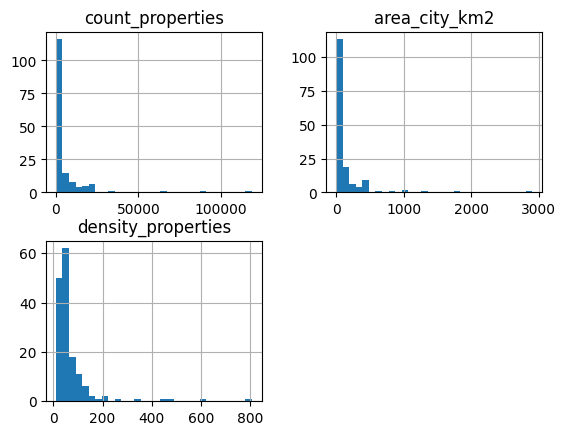

In [12]:
# hist plots
table_cities_count[['count_properties', 'area_city_km2', 'density_properties']].hist(bins=30)

In [13]:
# see top cities with more properties
table_cities_count.sort_values("count_properties", ascending=False).head(10)

,city_cluster,count_properties,area_city_km2,density_properties
0,0.0,118679,2903.853661,40.869484
12,12.0,87158,1790.617983,48.674816
21,21.0,67144,1262.912620,53.165990
9,9.0,34139,609.294647,56.030363
29,29.0,22551,271.880932,82.944397
48,48.0,22303,443.897147,50.243621
42,42.0,21622,968.555525,22.323965
16,16.0,21160,478.433650,44.227658
57,57.0,20894,426.496840,48.989812
2,2.0,20048,421.923013,47.515777


In [14]:
# see top cities with more density
(
    table_cities_count
    .sort_values("density_properties", ascending=False)
    .merge(
        gdf_cities.loc[:, ["city_cluster", "geometry"]],
        how="inner",
    )
    .pipe(gpd.GeoDataFrame)
    .explore(tiles="cartodbpositron")
    )

## Cut the cities with k-means

In [15]:
# get longitude & latitude of each property
gdf_properties["longitude"] = gdf_properties["geometry"].x
gdf_properties["latitude"] = gdf_properties["geometry"].y

### Example 1: CDMX

In [21]:
# use dbscan to cluster
CITY_CLUSTER_EXAMPLE = 0

# subset
gdf_properties_city = gdf_properties.query(f"city_cluster == {CITY_CLUSTER_EXAMPLE}").copy()

# 5 clusters
np.random.seed(42)  # for reproducibility in spectral clustering with amg
mb_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

# fit predict
gdf_properties_city["subcluster_city"] = mb_kmeans.fit_predict(
    gdf_properties_city[["longitude", "latitude"]]
    )


In [22]:
# count properties in each cluster
gdf_properties_city["subcluster_city"].value_counts()

subcluster_city
3    38485
1    27110
4    20759
0    20021
2    12304
Name: count, dtype: int64

<Axes: >

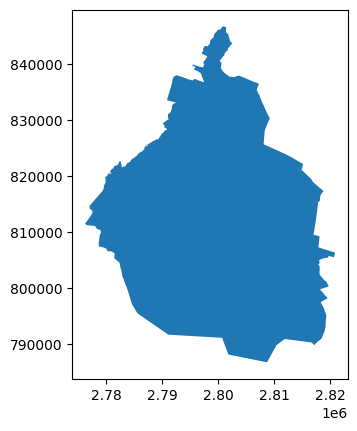

In [23]:
# get shape of cdmx and edomex
gdf_cdmx = geo_framework.Entidades(
    entidades=['09']
)

# change crs
gdf_cdmx = gdf_cdmx.to_crs("EPSG:6372")

# plot
gdf_cdmx.plot()

<Axes: >

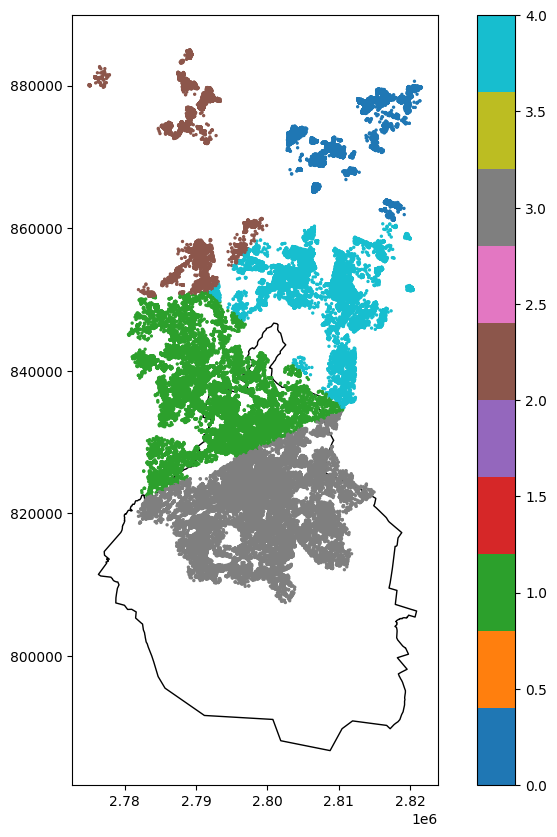

In [24]:
# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cdmx.plot(ax=ax, color='white', edgecolor='black')

(
    gdf_properties_city
    .pipe(gpd.GeoDataFrame)
    .plot(
        column="subcluster_city", legend=True, 
        figsize=(10, 10), ax=ax, cmap="tab10",
        markersize=2
        )
    )

### General Cuts

In [25]:
# function to subclusterize depending on the city
def subclusterize_city(gdf_properties, city_cluster, n_clusters=6):
    # subset
    gdf_properties_city = gdf_properties.query(f"city_cluster == {city_cluster}").copy()

    # mini batch clusters
    mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)

    # fit predict
    print("Fitting Clusters")
    gdf_properties_city["subcluster_city"] = mb_kmeans.fit_predict(
        gdf_properties_city[["longitude", "latitude"]]
        )

    # distribution of properties
    print(gdf_properties_city["subcluster_city"].value_counts())

    # plot
    print("Plotting")
    fig, ax = plt.subplots(figsize=(10, 10))

    (
        gdf_properties_city
        .pipe(gpd.GeoDataFrame)
        .plot(
            column="subcluster_city", legend=True, 
            figsize=(10, 10), ax=ax, cmap="tab10",
            markersize=2
            )
        )
    return


Fitting Clusters
subcluster_city
3    30850
1    22609
0    21725
2    20157
4    16400
5     6938
Name: count, dtype: int64
Plotting


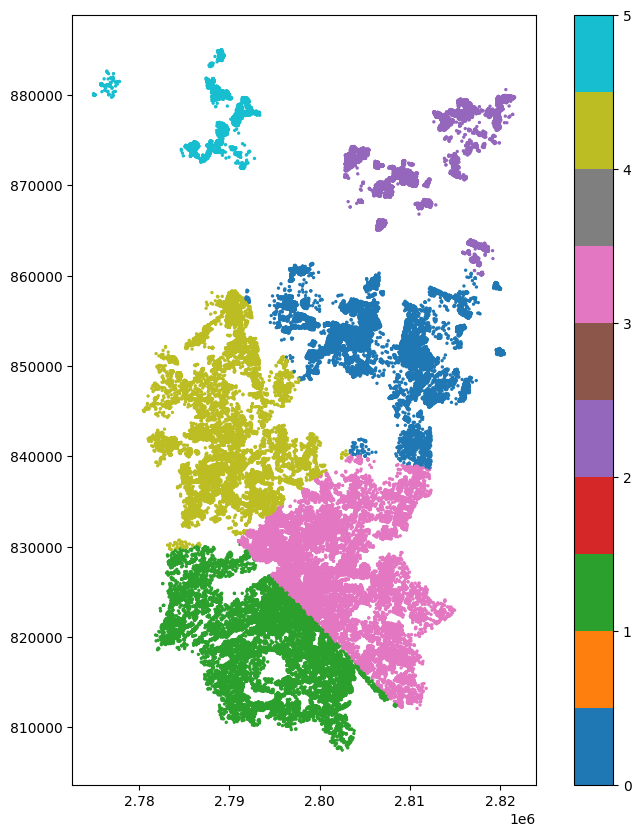

In [26]:
# to cdmx
subclusterize_city(gdf_properties, city_cluster=0, n_clusters=6)

Fitting Clusters
subcluster_city
0    25692
3    22189
1    16429
2    14010
4     8838
Name: count, dtype: int64
Plotting


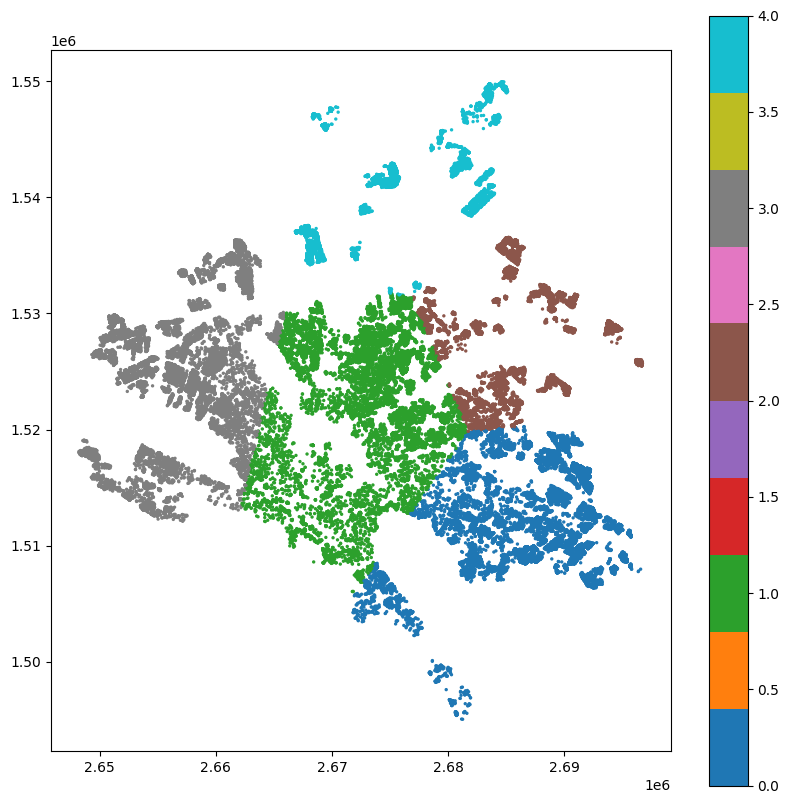

In [37]:
# to mty
subclusterize_city(gdf_properties, city_cluster=12, n_clusters=5)

Fitting Clusters
subcluster_city
0    18315
4    12617
5    11303
2     9165
3     7987
1     7757
Name: count, dtype: int64
Plotting


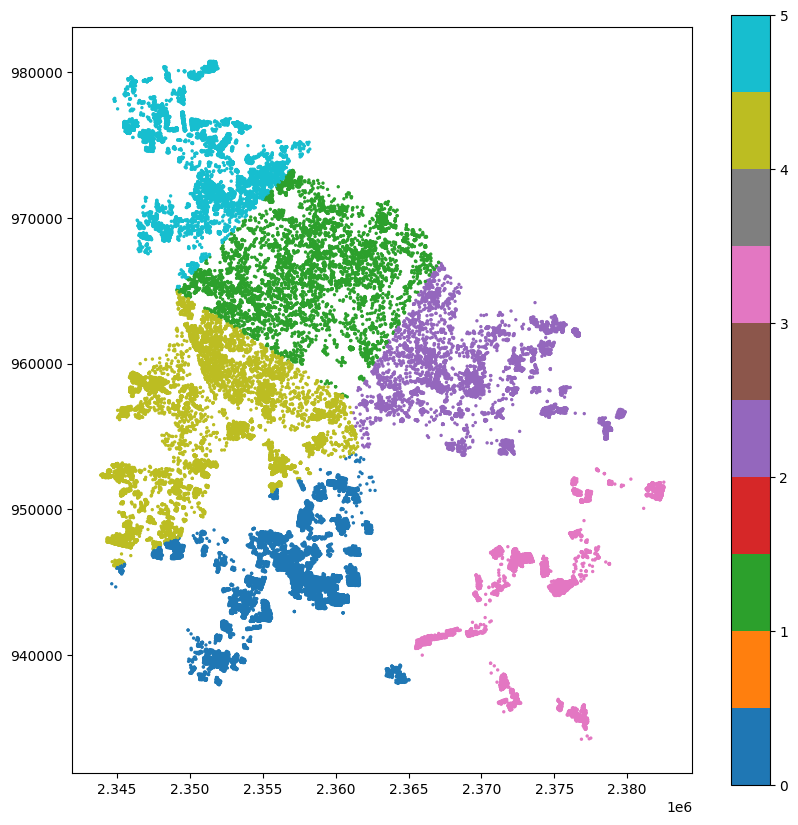

In [32]:
# to edomex
subclusterize_city(gdf_properties, city_cluster=21, n_clusters=6)

Fitting Clusters
subcluster_city
0    15039
2    10696
1     8404
Name: count, dtype: int64
Plotting


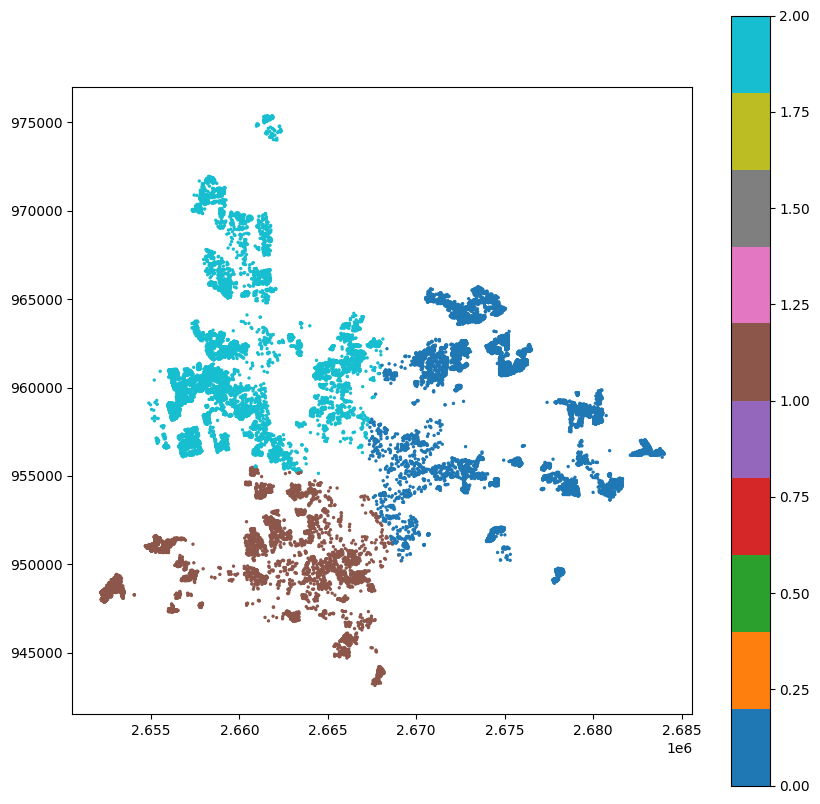

In [40]:
# to edomex
subclusterize_city(gdf_properties, city_cluster=9, n_clusters=3)

## Cut the cities with HDBSCAN (noup)

### Example 1: CDMX

In [50]:
# use dbscan to cluster
CITY_CLUSTER_EXAMPLE = 0

# subset
gdf_properties_city = gdf_properties.query(f"city_cluster == {CITY_CLUSTER_EXAMPLE}").copy()

# hdbscan
hdbscan = HDBSCAN(min_cluster_size=20, min_samples=10)

# fit predict
gdf_properties_city["subcluster_city"] = hdbscan.fit_predict(
    gdf_properties_city[["longitude", "latitude"]]
    )

In [51]:
# count properties in each cluster
gdf_properties_city["subcluster_city"].value_counts().sort_index()

subcluster_city
-1       29455
 0        2059
 1         100
 2          20
 3         326
         ...  
 1273       78
 1274       73
 1275       22
 1276       58
 1277       34
Name: count, Length: 1279, dtype: int64

<Axes: >

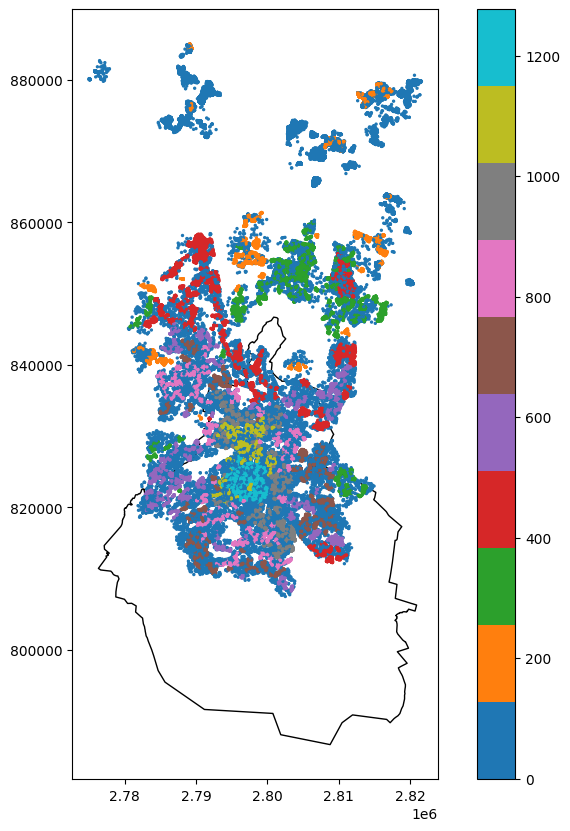

In [53]:
# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cdmx.plot(ax=ax, color='white', edgecolor='black')

(
    gdf_properties_city
    .pipe(gpd.GeoDataFrame)
    .plot(
        column="subcluster_city", legend=True, 
        figsize=(10, 10), ax=ax, cmap="tab10",
        markersize=2
        )
    )

## S2: ~~Cut the cities~~ Subset properties using KDTree

subset properties with radius R and generate a distance between properties

---
# Compare all vs all

Use a KDTree and direct distances

## S1: Define neighbors levels

### Find # of properties in different radius

In [10]:
# from crs 4326 to 6372
gdf_properties = gdf_properties.to_crs('EPSG:6372')

# get lon and lat
gdf_properties['longitude'] = gdf_properties.geometry.x
gdf_properties['latitude'] = gdf_properties.geometry.y

In [11]:
# define function to get poiunts at r distance
def get_neighbors(gdf, r):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )
    # count neighbors at r-km
    gdf[f'neighbors_{r}km'] = kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )
    return gdf

# get percentil of neighbors at N
def percentil_at_x(x, p):
    return x.gt(p).mean()

In [12]:
# get percentil of neighbors at N
N_MIN_NEIGHBORS = 30

# get neighbors at provided distances
list_distances = [0.1, 0.25, 0.5, 1, 2]

for r in tqdm(list_distances):
    gdf_properties = get_neighbors(gdf_properties, r)

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


In [13]:
# General
columns_neighbors = list(gdf_properties.columns[gdf_properties.columns.str.contains('neighbors')])

(
    gdf_properties
    .loc[:, columns_neighbors]
    .apply(
        lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
    )
    .sort_values()
)


neighbors_0.1km     0.381759
neighbors_0.25km    0.675250
neighbors_0.5km     0.918467
neighbors_1km       0.995120
neighbors_2km       1.000000
dtype: float64

In [14]:
# see it a property level
(
    gdf_properties
    .groupby(['property_type'])
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
        ),
        include_groups=False
    )
    .T
    .sort_index()
    .style.format("{:.0%}")
)

property_type,apartment,house
neighbors_0.1km,54%,33%
neighbors_0.25km,79%,64%
neighbors_0.5km,96%,91%
neighbors_1km,100%,99%
neighbors_2km,100%,100%


In [15]:
# now see it at state level
(
    gdf_properties
    .groupby(['id_entidad_f'])
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
        ),
        include_groups=False
    )
    .T
    .sort_index()
    .style.format("{:.0%}")
)

id_entidad_f,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
neighbors_0.1km,46%,30%,26%,8%,29%,25%,26%,24%,25%,31%,43%,26%,63%,43%,36%,36%,35%,34%,50%,29%,39%,45%,64%,28%,35%,28%,30%,37%,41%,29%,43%,44%
neighbors_0.25km,75%,50%,60%,25%,63%,61%,50%,65%,62%,62%,69%,56%,79%,74%,70%,62%,64%,65%,74%,57%,64%,78%,82%,62%,64%,62%,55%,62%,51%,55%,66%,63%
neighbors_0.5km,95%,83%,88%,84%,90%,91%,81%,92%,93%,91%,92%,87%,95%,94%,92%,87%,85%,89%,95%,80%,89%,95%,96%,94%,92%,91%,80%,92%,78%,86%,87%,88%
neighbors_1km,100%,99%,99%,100%,99%,100%,98%,100%,100%,100%,100%,99%,99%,100%,99%,99%,99%,100%,100%,98%,99%,100%,100%,100%,100%,100%,98%,100%,96%,99%,99%,100%
neighbors_2km,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-rese

<Axes: xlabel='percentil', ylabel='neighbors'>

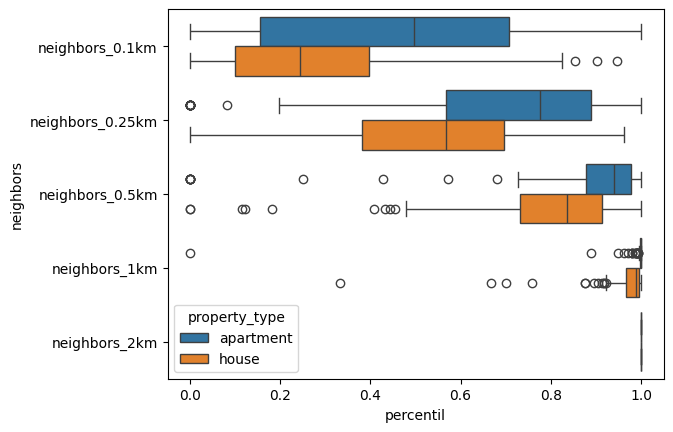

In [16]:
# now see it at city level
(
    gdf_properties
    .groupby(['city_cluster', 'property_type'])
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
        ),
        include_groups=False
    )
    .melt(ignore_index=False, var_name='neighbors', value_name='percentil')
    # boxplot of percentil by neighbors and hue by property type
    .pipe((sns.boxplot, 'data'), y='neighbors', x='percentil', hue='property_type')
)

In [17]:
# now see it at city level
(
    gdf_properties
    .groupby('city_cluster')
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
        ),
        include_groups=False
    )
    .melt(ignore_index=False, var_name='neighbors', value_name='percentil')
    .groupby('neighbors')
    .describe()
)

percentil                                                    \
                     count      mean       std       min       25%       50%   
neighbors                                                                      
neighbors_0.1km      158.0  0.347609  0.231635  0.000000  0.188421  0.324055   
neighbors_0.25km     158.0  0.584933  0.230065  0.000000  0.445078  0.627755   
neighbors_0.5km      158.0  0.826788  0.136269  0.113402  0.772265  0.858400   
neighbors_1km        158.0  0.980912  0.025382  0.862637  0.976975  0.991459   
neighbors_2km        158.0  1.000000  0.000000  1.000000  1.000000  1.000000   

                                      
                       75%       max  
neighbors                             
neighbors_0.1km   0.483460  0.963351  
neighbors_0.25km  0.736777  0.984293  
neighbors_0.5km   0.924029  0.999304  
neighbors_1km     0.996781  1.000000  
neighbors_2km     1.000000  1.000000

In [18]:
# see decsription of neighbors
(
    gdf_properties
    .loc[:, columns_neighbors + ['property_type']]
    .groupby('property_type')
    # get median
    .median()
    .T
)

property_type,apartment,house
neighbors_0.1km,37.0,13.0
neighbors_0.25km,96.0,49.0
neighbors_0.5km,219.0,130.0
neighbors_1km,498.0,344.0
neighbors_2km,1142.0,916.0


^^^ looks sweatspot between 0.25 for apartments but 0.5 for houses

In [19]:
# see properties where neighbors at 500m are less than 30
print(gdf_properties['neighbors_0.5km'].lt(10).sum())
print(gdf_properties['neighbors_0.5km'].lt(10).mean())

7882
0.009241075772835082


<Axes: xlabel='id_entidad_f'>

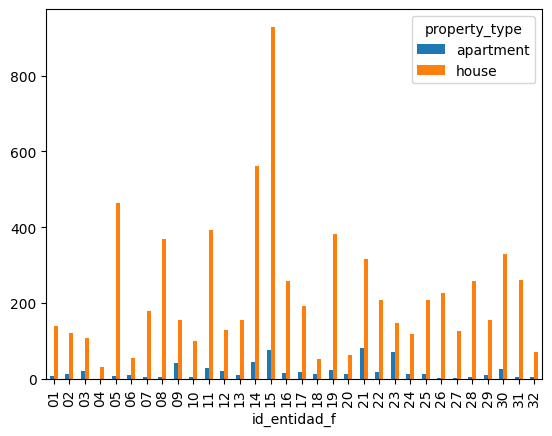

In [20]:
# see in which id_entidad_f are the properties with less than 30 neighbors at 500m
s_properties_with_less_minimum_req = (
    gdf_properties
    .loc[gdf_properties['neighbors_0.5km'].lt(10), ['id_entidad_f', 'property_type']]
    .groupby(['id_entidad_f', 'property_type'])
    .size()
    )

# plot barplot hue by property type
(
    s_properties_with_less_minimum_req
    .unstack()
    .plot(kind='bar', stacked=False)
)

### Specific radius for cities

In [21]:
# set
big_cities_list = [0, 12, 21, 9]
dict_radius = {
    'big_city':{
        'house': 1,
        'apartment': 1
    },
    'small_city':{
        'house': 1,
        'apartment': 1
    }
}


In [22]:
# define function to get poiunts at r distance
def get_neighbors_at_r(gdf, r):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )
    # count neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )


In [23]:
# init column
gdf_properties['neighbors'] = np.nan

# map big cities or small cities
gdf_properties['city_type'] = np.where(
    gdf_properties['city_cluster'].isin(big_cities_list), 'big_city', 'small_city'
)

# get neighbors at provided distances
for city_type, dict_radius_city in tqdm(dict_radius.items()):
    for property_type, radius in dict_radius_city.items():
        # mask
        mask = (
            (gdf_properties['city_type'] == city_type) &
            (gdf_properties['property_type'] == property_type)
        )
        # get neighbors
        gdf_properties.loc[mask, 'neighbors'] = get_neighbors_at_r(
            gdf_properties.loc[mask, ['longitude', 'latitude']],
            r=radius
        )

100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


In [24]:
# see neighbors
gdf_properties['neighbors'].describe()

count    852931.000000
mean        432.602810
std         412.197184
min           1.000000
25%         142.000000
50%         300.000000
75%         591.000000
max        2979.000000
Name: neighbors, dtype: float64

<Axes: >

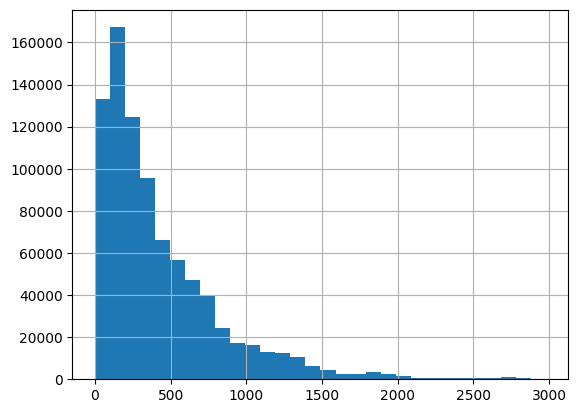

In [25]:
# see hist
gdf_properties['neighbors'].hist(bins=30)

<Axes: xlabel='city_type'>

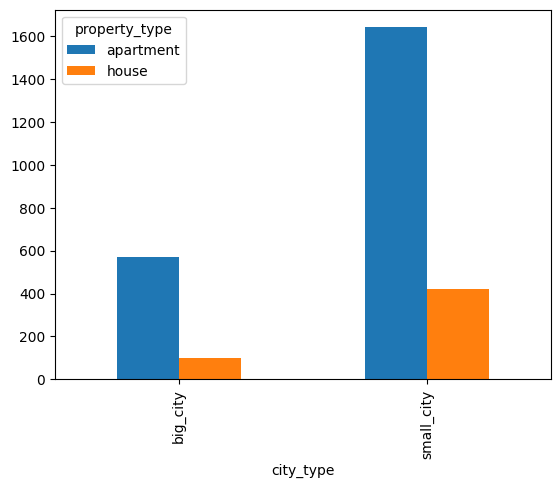

In [26]:
# see how many are less than 10 by city type and property type
(
    gdf_properties
    .loc[gdf_properties['neighbors'].lt(10)]
    .groupby(['city_type', 'property_type'])
    .size()
    # plot barplot hue by property type
    .unstack()
    .plot(kind='bar', stacked=False)
)

In [27]:
gdf_properties['city_type'].value_counts()

city_type
small_city    545811
big_city      307120
Name: count, dtype: int64

In [28]:
(
        gdf_properties
    .loc[gdf_properties['neighbors'].lt(10)]
    .groupby(['city_type', 'property_type'])
    .size()
)

city_type   property_type
big_city    apartment         570
            house              98
small_city  apartment        1642
            house             421
dtype: int64

In [29]:
# see proprtion on how many are less than 10 by city type and property type
(
    gdf_properties
    .loc[gdf_properties['neighbors'].lt(10)]
    .groupby(['city_type', 'property_type'])
    .size()
    .div(gdf_properties['city_type'].value_counts(), axis=0, level='city_type')
    .unstack()

)

property_type,apartment,house
city_type,,
big_city,0.001856,0.000319
small_city,0.003008,0.000771


In [30]:
# how many less than 3
(
    gdf_properties
    .loc[gdf_properties['neighbors'].le(3)]
    .groupby(['city_type', 'property_type'])
    .size()
    .div(gdf_properties['city_type'].value_counts(), axis=0, level='city_type')
    .unstack()
)

property_type,apartment,house
city_type,,
big_city,0.000492,0.000036
small_city,0.000718,0.000097


notes:~~
1. for the big cities
    - houses: ratio of neighbors at 500m
    - apartments: ratio of neighbors at 250m
    
2. for the rest of the cities
    - houses: ratio of neighbors at 1000m
    - apartments: ratio of neighbors at 500m
    ~~

same for all cities & properties

## S2: Get neighbors

### Query Ball

In [159]:
# subset
gdf_properties_work = gdf_properties.query("city_cluster == 0").copy().reset_index(drop=True)

# see
gdf_properties_work.shape

(118679, 54)

In [160]:
# for each property search the neighbors at 1000m using kdtree
kdtree = KDTree(
    data=gdf_properties_work[['longitude', 'latitude']],
)

# get neighbors at r-km
gdf_properties_work['neighbors_list'] = kdtree.query_ball_point(
    gdf_properties_work[['longitude', 'latitude']],
    r=1_000,
    workers=-1
)

In [161]:
# see neighbors
gdf_properties_work['neighbors_list'].tail(10)

118669    [334, 335, 643, 644, 645, 646, 647, 648, 689, ...
118670    [334, 335, 643, 644, 645, 646, 647, 648, 689, ...
118671    [334, 335, 643, 644, 645, 646, 647, 648, 689, ...
118672    [334, 335, 643, 644, 645, 646, 647, 648, 689, ...
118673    [147, 150, 151, 161, 162, 163, 164, 189, 331, ...
118674    [147, 148, 150, 151, 152, 161, 162, 163, 164, ...
118675    [147, 148, 150, 151, 152, 161, 162, 163, 164, ...
118676    [913, 2501, 2733, 7742, 9066, 11570, 12631, 15...
118677    [147, 148, 150, 151, 152, 161, 162, 163, 164, ...
118678    [147, 148, 150, 151, 152, 161, 162, 163, 164, ...
Name: neighbors_list, dtype: object

### Expand

In [162]:
(
    gdf_properties_work
    .loc[:, cols_to_stay]
    .tail(1)
)

,property_id,longitude,latitude,superficie_terreno,superficie_construida,elevador,niveles,vida_util_remanente,recamaras,banos,medio_banos,estacionamiento,fecha_avaluo
118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18


In [163]:
# expand list for last property
cols_to_stay = [
    'property_id',
    # variables to stay
    # geographic
    'longitude', 'latitude',
    # topology
    'superficie_terreno', 'superficie_construida',
    # characteristics
    'elevador', 'niveles', 'vida_util_remanente', 
    'recamaras', 'banos', 'medio_banos', 'estacionamiento',
    # time
    'fecha_avaluo',
]

# get possible neighbors
gdf_neighbors = (
    gdf_properties_work
    .tail(1)
    .loc[:, cols_to_stay + ['neighbors_list']]
    .explode('neighbors_list')
    .rename(columns={'neighbors_list': 'property_id_neighbor'})
    .query("index != property_id_neighbor")
    .reset_index()
    # join property_id_neighbor with gdf_properties_work using the index
    .merge(
        (
            gdf_properties_work
            .assign(index=gdf_properties_work.index)
            .loc[:, ['index'] + cols_to_stay]
            ),
        how='left',
        left_on='property_id_neighbor',
        right_on='index',
        suffixes=('_own', '_neighbor'),

    )
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor']),
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372", geometry='geometry')
)
gdf_neighbors

,index_own,property_id_own,longitude_own,latitude_own,superficie_terreno_own,superficie_construida_own,elevador_own,niveles_own,vida_util_remanente_own,recamaras_own,banos_own,medio_banos_own,estacionamiento_own,fecha_avaluo_own,property_id_neighbor,index_neighbor,property_id_neighbor,longitude_neighbor,latitude_neighbor,superficie_terreno_neighbor,superficie_construida_neighbor,elevador_neighbor,niveles_neighbor,vida_util_remanente_neighbor,recamaras_neighbor,banos_neighbor,medio_banos_neighbor,estacionamiento_neighbor,fecha_avaluo_neighbor,geometry
0,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,147,147,0b81f7180a534348a0855a179d259b5f,2.820802e+06,879886.108832,90,69,0.0,2,70,2,1,1,1,2022-04-07,POINT (2820802.204 879886.109)
1,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,148,148,124c1659ef0d4291a4d8174243d66206,2.820487e+06,879258.022237,90,72,0.0,2,70,3,1,1,1,2022-03-22,POINT (2820486.849 879258.022)
2,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,150,150,74a657cabf8644d19a1657e128b21cd6,2.820571e+06,879787.339957,158,97,0.0,2,70,3,2,1,2,2022-02-04,POINT (2820570.606 879787.340)
3,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,151,151,4cc30db25a274e0f97e56d49449c270d,2.820559e+06,879775.763204,90,97,0.0,2,70,3,2,1,2,2022-02-08,POINT (2820558.694 879775.763)
4,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,152,152,6b781044713f4431b072f1e4f1c18bd4,2.820414e+06,879804.525077,90,97,0.0,2,70,3,2,1,2,2022-06-28,POINT (2820413.663 879804.525)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,118662,118662,b11d699b155b464c98ed4eb696e13bed,2.820580e+06,879881.707965,90,79,2.0,2,60,3,1,1,1,2022-12-08,POINT (2820580.380 879881.708)
1211,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,118673,118673,19bfd3e0583f44b1bdbe2f8b6d65d628,2.821548e+06,879666.990573,118,79,2.0,2,70,3,1,1,1,2023-01-31,POINT (2821548.042 879666.991)
1212,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,118674,118674,3ce971986e8d40d289761daaa16e8b07,2.821241e+06,879686.443238,118,79,2.0,2,70,3,1,1,1,2023-01-31,POINT (2821241.255 879686.443)
1213,118678,8606510ad224492f898bcd2c9c07295a,2.821147e+06,879595.93,67,69,2.0,2,70,2,1,1,1,2023-07-18,118675,118675,4fca7e24dc0747d393f16787dec9ba4d,2.821067e+06,879608.762851,67,69,2.0,2,70,2,1,1,1,2023-06-27,POINT (2821066.617 879608.763)


note: 
    query_ball_point includes the point itself, so we need to remove it

<Axes: >

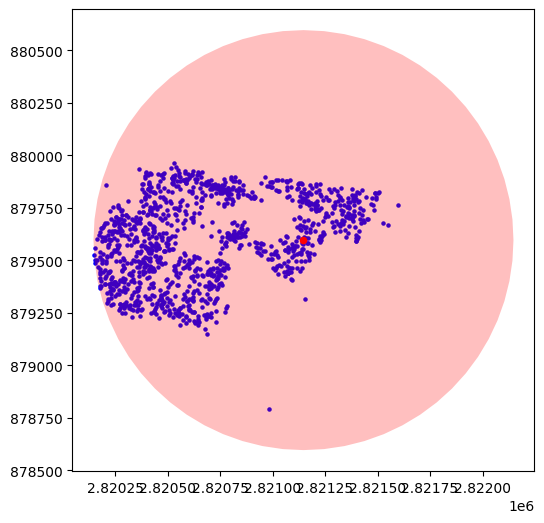

In [164]:
# see neighbors
fig, ax = plt.subplots(figsize=(6, 6))

# neighbors
(
    gdf_neighbors
    .loc[:, ['geometry']]
    .plot(
        color='blue', ax=ax, markersize=5
    )
)

# point
(
    gdf_properties_work
    .tail(1)
    .plot(
        color='red', ax=ax, markersize=20
    )
)

# generate a buffer of size 1000m for the last property
(
    gdf_properties_work
    .tail(1)
    .buffer(1_000)
    .plot(ax=ax, color='red', alpha=0.25)
)

## S3: Get competitors

### ~~Get covariance matrix~~

In [211]:
# get cov matrix of superficie_terreno, superficie_construida
cov_sup = gdf_properties_work[['superficie_terreno', 'superficie_construida']].cov()

# see
cov_sup

,superficie_terreno,superficie_construida
superficie_terreno,18371.281622,4836.792780
superficie_construida,4836.792780,4948.308998


In [213]:
# get eigenvalues of cov matrix
eigenvalues = 1/np.linalg.eigvals(cov_sup)
eigenvalues

array([5.01691739e-05, 2.95243742e-04])

### Get distance

In [165]:
# get distances
def get_distance_comps(dfx):
    # get geographic distance
    return pd.Series({
        # property id
        'property_id': dfx['property_id_neighbor'].values[0],
        # geographic distance
        'geo_distance': np.sqrt(
            (dfx['longitude_own'] - dfx['longitude_neighbor'])**2
            + (dfx['latitude_own'] - dfx['latitude_neighbor'])**2
        ),
        # topology distance
        'terrain_distance': np.abs(1-dfx['superficie_terreno_neighbor'] / dfx['superficie_terreno_own']),
        'built_distance': np.abs(1-dfx['superficie_construida_neighbor'] / dfx['superficie_construida_own']),
        # characteristics distance
        'characteristics_distance': np.sqrt(
            (dfx['elevador_own'] - dfx['elevador_neighbor'])**2
            (dfx['niveles_own'] - dfx['niveles_neighbor'])**2
            (dfx['vida_util_remanente_own'] - dfx['vida_util_remanente_neighbor'])**2
            (dfx['recamaras_own'] - dfx['recamaras_neighbor'])**2
            (dfx['banos_own'] - dfx['banos_neighbor'])**2
            (dfx['medio_banos_own'] - dfx['medio_banos_neighbor'])**2
            (dfx['estacionamiento_own'] - dfx['estacionamiento_neighbor'])**2
        ),
        # time distance
        'time_distance': np.abs(
            np.abs((dfx['fecha_avaluo_own'] - dfx['fecha_avaluo_neighbor']).days)
        )
    })

# get distances
gdf_neighbors_distance = (
    gdf_neighbors
    .apply(get_distance_comps, axis=1)
    .assign(
        total_distance=lambda x: x.filter(like='distance').sum(axis=1)
    )
    .sort_values('total_distance')
)
gdf_neighbors_distance

,property_id,geo_distance,terrain_distance,built_distance,characteristics_distance,time_distance,total_distance
687,75609.0,10.236636,0.343284,0.144928,1.000000,4.0,15.724847
564,58951.0,13.643037,0.343284,0.144928,1.000000,6.0,21.131248
1214,118677.0,26.114505,0.000000,0.000000,0.000000,0.0,26.114505
897,112786.0,23.941530,0.343284,0.144928,2.236068,5.0,31.665809
546,58858.0,20.376862,0.000000,0.000000,1.414214,23.0,44.791075
...,...,...,...,...,...,...,...
192,10165.0,955.684223,0.567164,0.927536,2.645751,1629.0,2588.824674
993,117935.0,940.515047,0.343284,0.405797,1.414214,1649.0,2591.678342
567,59609.0,960.528480,0.611940,0.130435,2.236068,1635.0,2598.506923
527,57218.0,964.399344,0.567164,0.956522,2.645751,1632.0,2600.568781


In [143]:
type(gdf_neighbors_distance)


pandas.core.series.Series

---
# Sandbox

In [97]:
gdf_properties

,property_id,valor_fisico_construccion,id_avaluo,fecha_avaluo,colonia,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,niveles,cve_ref_proximidad_urbana,cve_nivel_equipamiento_urbano,valor_mercado,valor_concluido_total,nivel,unidades_rentables,edad_anios,precio_m2,vida_util_remanente,cve_clasificacion_zona,cve_vigilancia,regimen_propiedad,tipo_vialidad,id_uv,id_municipio,id_entidad_f,clave_controlador,clave_valuador,id_otorgante,cp,latitud,longitud,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,valor_fisico_terreno_m2,geometry,city_cluster_left,area_city_km2_left,city_cluster_right,area_city_km2_right,city_cluster,area_city_km2,longitude,latitude,neighbors_0.1km,neighbors_0.25km,neighbors_0.5km,neighbors_1km,neighbors_2km,property_type
0,66cf10199ef943a5a5ff82129e53d5d7,1611371.52,090682009R0225150,2020-05-27,SD,4,2,4.0,1.0,4,1,1,4305275,4305000,3,1,25,12353,45,4,NaN,PRIVADA INDIVIDUAL,NaN,9068,003,09,1742315,1400027,30001,4600,19.310875,-99.158103,2,1,0,0,143,348,0,348,8918.000000,POINT (2797822.489 815572.062),0.0,2903.853661,0.0,2903.853661,0.0,2903.853661,2.797822e+06,8.155721e+05,3,5,26,306,811,apartment
1,f84f9a0c784f491eab6bb100b513a95b,460588.28,090682015R0258032,2020-07-23,SD,3,2,4.0,2.0,3,2,1,1351682,1352000,3,1,25,12482,35,3,NaN,PRIVADA INDIVIDUAL,NaN,9068,058,15,1742315,1400027,30001,57100,19.491722,-99.065361,2,2,0,1,113,108,0,108,6151.000000,POINT (2807131.800 835725.131),0.0,2903.853661,0.0,2903.853661,0.0,2903.853661,2.807132e+06,8.357251e+05,3,21,51,140,396,apartment
2,7ddd5a94feed4955a809f986d95722d8,1029107.14,090762015R0043870,2020-10-05,SD,4,2,4.0,2.0,1,2,1,2544900,2545000,0,1,1,14970,69,4,NaN,PRIVADA INDIVIDUAL,NaN,9076,121,15,402644,1844394,30001,54743,19.633393,-99.213541,3,2,0,1,200,170,0,170,5620.000000,POINT (2791321.912 851047.443),0.0,2903.853661,0.0,2903.853661,0.0,2903.853661,2.791322e+06,8.510474e+05,1,7,25,203,1192,apartment
3,d2e75fb3b385461995bf8d34b9d1fdfb,598308.77,090832009R0615780,2020-10-22,SD,4,2,4.0,2.0,2,2,1,2906000,2906000,3,1,35,20862,35,4,NaN,PRIVADA INDIVIDUAL,NaN,9083,003,09,1639115,1844554,30001,4480,19.333061,-99.114525,6,2,0,0,107,139,0,139,18149.000000,POINT (2802339.433 818111.830),0.0,2903.853661,0.0,2903.853661,0.0,2903.853661,2.802339e+06,8.181118e+05,6,13,50,247,923,apartment
4,6f1194f9853443219e63f4a3222b010e,144720.00,090682015R0226052,2020-05-27,SD,4,2,4.0,2.0,1,3,1,535697,536000,3,1,26,9925,44,4,NaN,PRIVADA INDIVIDUAL,NaN,9068,058,15,1742315,1400027,30001,57100,19.486586,-99.052833,2,1,0,0,84,54,0,54,4544.800000,POINT (2808454.380 835185.302),0.0,2903.853661,0.0,2903.853661,0.0,2903.853661,2.808454e+06,8.351853e+05,3,7,38,143,535,apartment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853028,3df99182d51044d08a35cf11de20dc04,380094.00,31003233110081800,2023-12-14,FRACCIONAMIENTO DESPERTARE RES,4,3,6.0,2.0,1,3,4,537000,537000,3,1,0,11019,70,5,1.0,PRIVADA COLECTIVA,2.0,31003,041,31,1004316,1844548,30001,97370,20.917209,-89.543248,2,1,0,1,102,48,0,48,1073.614608,POINT (3788505.922 1045793.814),2.0,421.923013,2.0,421.923013,2.0,421.923013,3.788506e+06,1.045794e+06,7,16,24,442,1102,house
853029,27774d8b8fd94d74ab3aa47569a5de07,996696.00,31003233110081800,2023-12-14,FRACC SERAPIO RENDON,4,2,4.0,2.0,2,2,4,1193000,1193000,3,1,20,7964,50,3,1.0,PRIVADA INDIVIDUAL,2.0,31003,050,31,1004316,1300409,30001,97285,20.929653,-89.614767,2,2,0,1,120,147,2,149,1349.495000,POINT (3781008.319 1046519.594),2.0,421.923013,2.0,421.923013,2.0,421.923013,3.781008e+06,1.046520e+06,5,11,35,156,375,apartment
853030,abdf8341fb43426faf32c4baf2ff22eb,996696.00,31003233110082000,2023-12-15,FRACC SERAPIO RENDON,4,2,4.0,2.0,2,2,4,1193000,1193000,3,1,20,7964,50,3,1.0,PRIVADA INDIVIDUAL,2.0,31003,050,31,1004316,1300409,30001,97285,20.929653,-

In [153]:
# see nan values in gdf_neighbors
gdf_neighbors.isna().sum()

index_own                          0
property_id_own                    0
longitude_own                      0
latitude_own                       0
superficie_terreno_own             0
superficie_construida_own          0
elevador_own                       0
niveles_own                        0
vida_util_remanente_own            0
recamaras_own                      0
banos_own                          0
medio_banos_own                    0
estacionamiento_own                0
fecha_avaluo_own                   0
property_id_neighbor               0
index_neighbor                     0
property_id_neighbor               0
longitude_neighbor                 0
latitude_neighbor                  0
superficie_terreno_neighbor        0
superficie_construida_neighbor     0
elevador_neighbor                 56
niveles_neighbor                   0
vida_util_remanente_neighbor       0
recamaras_neighbor                 0
banos_neighbor                     0
medio_banos_neighbor               0
e

In [181]:
# see niveles
(
    gdf_properties
    .groupby("property_type")
    ['niveles']
    .describe()
    )

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
apartment,207351.0,1.456550,2.045096,0.0,1.0,1.0,1.0,65.0
house,645580.0,1.622175,0.627290,0.0,1.0,2.0,2.0,53.0


In [193]:
# see quantiles
(
    gdf_properties
    .groupby("property_type")
    # see quantiles 1-10
    ['niveles']
    .quantile(q=np.linspace(0.1, 1, 10))
    .unstack()
    )

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
property_type,,,,,,,,,,
apartment,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,65.0
house,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,53.0


In [202]:
# see recamaras
(
    gdf_properties
    .groupby("property_type")
    ['banos']
    .describe()
    )

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
apartment,207351.0,1.286823,0.564870,0.0,1.0,1.0,1.0,9.0
house,645580.0,1.508832,0.827605,0.0,1.0,1.0,2.0,12.0


In [200]:
# see recamaras
(
    gdf_properties
    .groupby("property_type")
    ['banos']
    .apply(lambda x: x.eq(0).sum())
    )

property_type
apartment     4
house        11
Name: banos, dtype: int64

In [199]:
# see recamaras
(
    gdf_properties
    .groupby("property_type")
    ['recamaras']
    .apply(lambda x: x.eq(0).sum())
    )

property_type
apartment    2
house        7
Name: recamaras, dtype: int64

In [198]:
# see recamaras
(
    gdf_properties
    .groupby("property_type")
    ['recamaras']
    .describe()
    )

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
apartment,207351.0,2.106274,0.411073,0.0,2.0,2.0,2.0,8.0
house,645580.0,2.411828,0.737355,0.0,2.0,2.0,3.0,47.0


In [197]:
np.sqrt(0.9)

0.9486832980505138

In [179]:
# see niveles
(
    gdf_properties
    .groupby("property_type")
    ['niveles']
    .apply(lambda x: x.gt(5).sum())
    )

property_type
apartment    4225
house          93
Name: niveles, dtype: int64

In [182]:
# vida util
(
    gdf_properties
    ['vida_util_remanente']
    .describe()
    )

count    852931.000000
mean         58.785639
std          11.039683
min           0.000000
25%          53.000000
50%          60.000000
75%          69.000000
max          80.000000
Name: vida_util_remanente, dtype: float64

In [154]:
# see nan value in gdf_properties
gdf_properties.isna().sum()[gdf_properties.isna().sum().gt(0)]

elevador           28371
cve_vigilancia    316447
tipo_vialidad     316447
city_cluster         487
area_city_km2        487
dtype: int64

In [38]:
# search
gdf_cities.query("city_cluster == 9")

,city_cluster,geometry,id_entidad_f,id_municipio,area_city_km2
9,9,"POLYGON ((2667661.020 943159.128, 2652357.365 ...",22,006,609.294647


In [152]:
gdf_properties_work.shape

(118679, 55)